# Multi-tissue classification Ovarian cancer

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation                                                           
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model                                                 
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



**Step: 1 Environment Setup**

In [1]:
# Data manipulation and analysis
import os 
import numpy as np
import pandas as pd
from glob import glob

# Image processing
from PIL import Image
import cv2


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2: Loading Data**


In [2]:
# Assuming the dataset is in a folder named 'dataset'
data_dir = '/kaggle/input/tcga-ovarian-histological-images/ovarian'

# Get class names from subdirectory names
classes = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
print("Classes:", classes)


# Initialize lists to hold file paths and labels
image_paths = []
image_labels = []

# Map class names to numerical labels
class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}
print("Class to label mapping:", class_to_label)

# Loop through each class directory and collect file paths
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Get all image file paths in the class directory
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    # Append file paths and labels
    image_paths.extend(image_files)
    image_labels.extend([class_to_label[class_name]] * len(image_files))
    #print(f"Processing {len(image_files)} images for class '{class_name}'")

print(f"Total images found: {len(image_paths)}")

Classes: ['non-tumour', 'tumour']
Class to label mapping: {'non-tumour': 0, 'tumour': 1}
Total images found: 33110


**3. Analyzing Class Distribution**

Class counts:
 class_name
tumour        19747
non-tumour    13363
Name: count, dtype: int64


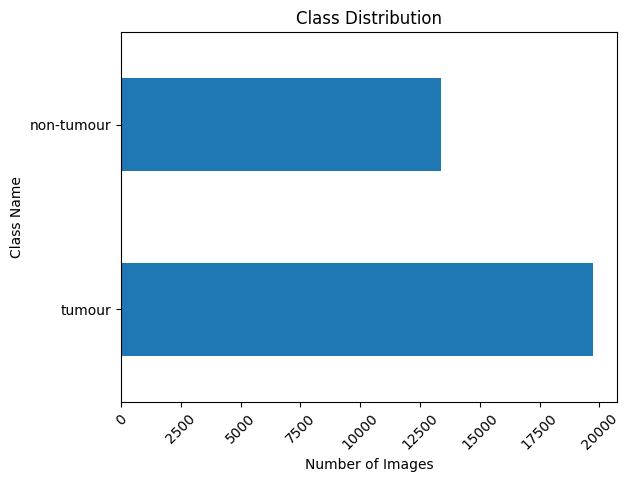

In [3]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
label_to_class = {v: k for k, v in class_to_label.items()}
df['class_name'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['class_name'].value_counts()
print("Class counts:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 



In [4]:
df.head()

,image_path,label,class_name
0,/kaggle/input/tcga-ovarian-histological-images...,0,non-tumour
1,/kaggle/input/tcga-ovarian-histological-images...,0,non-tumour
2,/kaggle/input/tcga-ovarian-histological-images...,0,non-tumour
3,/kaggle/input/tcga-ovarian-histological-images...,0,non-tumour
4,/kaggle/input/tcga-ovarian-histological-images...,0,non-tumour


In [5]:
df.tail()

,image_path,label,class_name
33105,/kaggle/input/tcga-ovarian-histological-images...,1,tumour
33106,/kaggle/input/tcga-ovarian-histological-images...,1,tumour
33107,/kaggle/input/tcga-ovarian-histological-images...,1,tumour
33108,/kaggle/input/tcga-ovarian-histological-images...,1,tumour
33109,/kaggle/input/tcga-ovarian-histological-images...,1,tumour


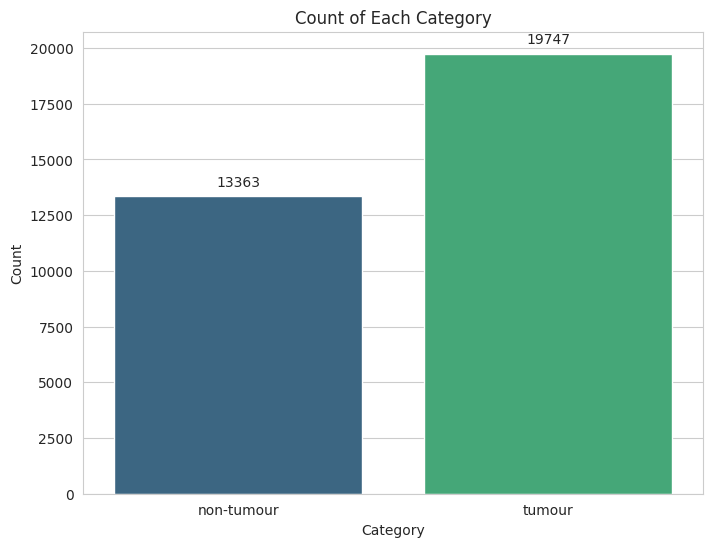

In [6]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x=df['label'].map(label_to_class), palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

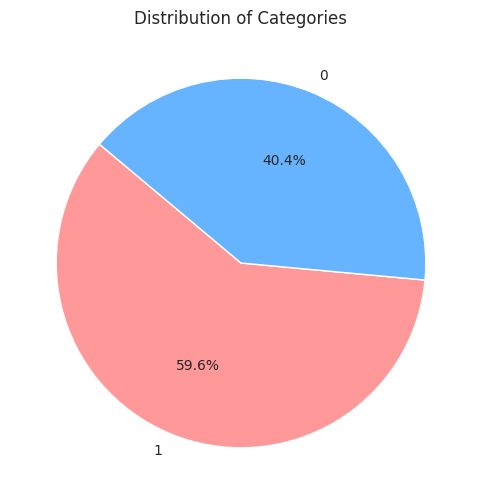

In [7]:
#Show distribution of classes in pye chart
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

plt.title("Distribution of Categories")

plt.show() 

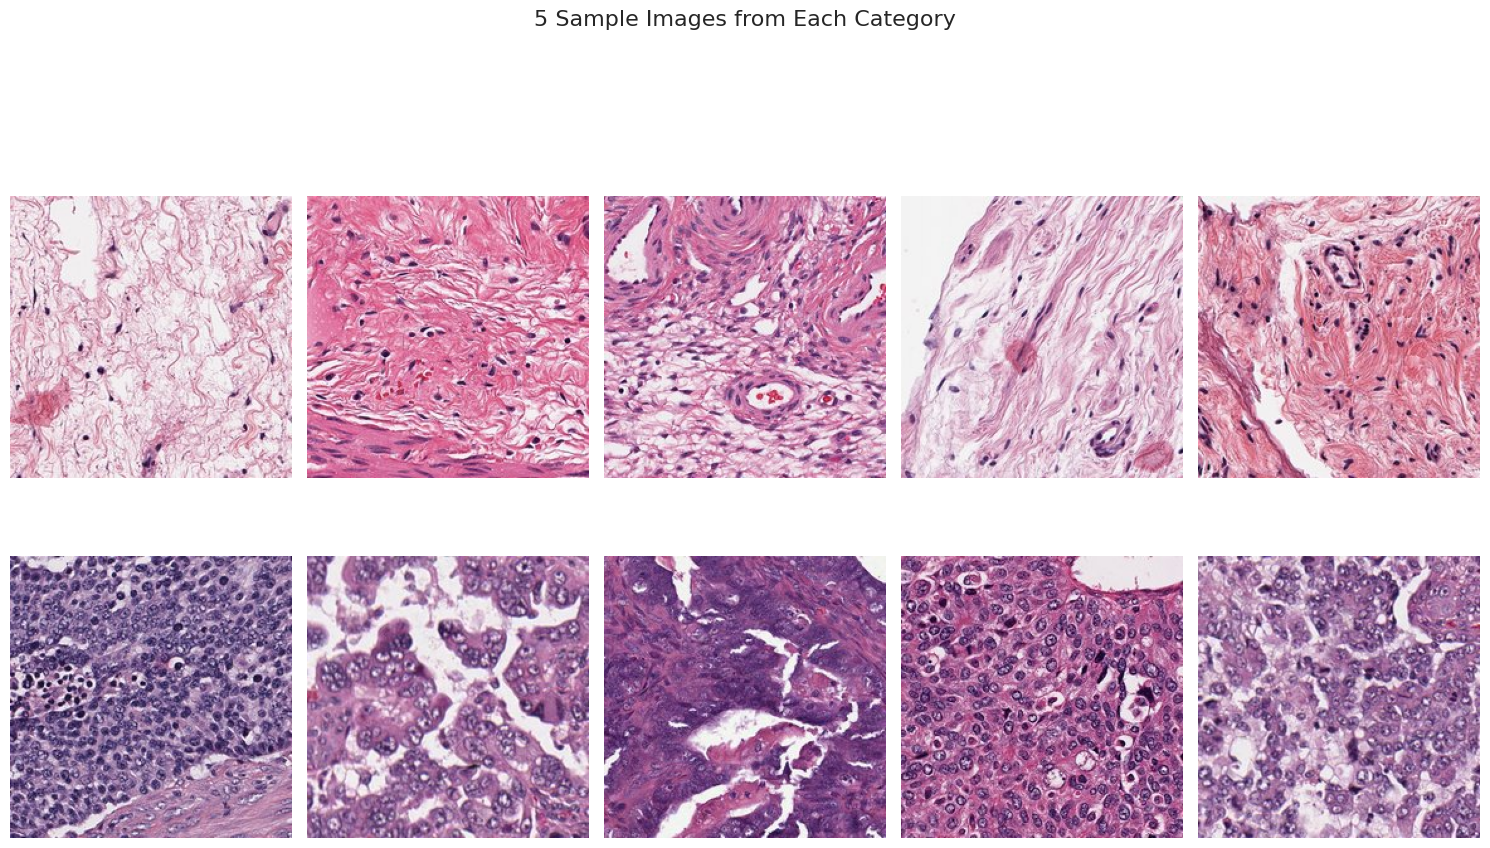

In [8]:
num_images = 5

fig, axes = plt.subplots(len(label_to_class), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(label_to_class):

    sample_images = df[df['label'] == category].sample(num_images, random_state=42)

    for j, image_path in enumerate(sample_images['image_path']):

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(category, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
     


**Step 5: Split the Dataset**


In [9]:
# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42,
    shuffle = True
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
    shuffle = True
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")




Training set size: 26488
Validation set size: 3311
Test set size: 3311


**6. Preparing Data Generators**


6.1. Training Data Generator


In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)



Found 26488 validated image filenames belonging to 2 classes.


6.2. Validation Data Generator

In [11]:
valid_gen_new = ts_gen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
    
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_name',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
    
)

Found 3311 validated image filenames belonging to 2 classes.
Found 3311 validated image filenames belonging to 2 classes.


**9. Building and Configuring the CNN Model**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,282 (105.14 MB)

 Trainable params: 12,846,594 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

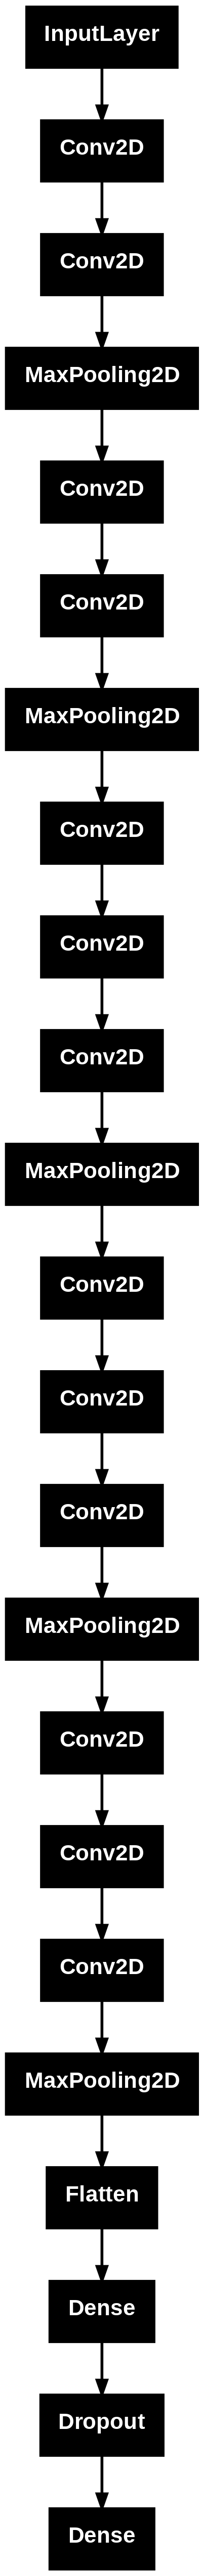

In [12]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

x = vgg16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=x)


model.summary()
tf.keras.utils.plot_model(model)

In [13]:
# Compile the model
#tf.keras.losses.binary_crossentropy
#model.compile(optimizer= 'adam' , loss=  tf.keras.losses.SparseCategoricalCrossentropy, metrics=['accuracy']) 
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=7,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

callbacks = [early_stopping, reduce_lr]

Step 7: Cross-validating model        


In [15]:
steps_per_epoch = len(train_df) *2 // batch_size  # Oversampling will effectively double the data
# Train the model
history = model.fit(
    train_gen_new,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data= valid_gen_new,  #(X_val, y_val),
    #class_weight=class_weights,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


414/827 ━━━━━━━━━━━━━━━━━━━━ 2:27 357ms/step - accuracy: 0.8685 - loss: 0.9674

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


827/827 ━━━━━━━━━━━━━━━━━━━━ 211s 223ms/step - accuracy: 0.8936 - loss: 0.6544 - val_accuracy: 0.9559 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 2/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9531 - loss: 0.1338 - val_accuracy: 0.9526 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 3/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9543 - loss: 0.1279 - val_accuracy: 0.9568 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 4/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9617 - loss: 0.1096 - val_accuracy: 0.9656 - val_loss: 0.1087 - learning_rate: 0.0010
Epoch 5/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9630 - loss: 0.1021 - val_accuracy: 0.9619 - val_loss: 0.1169 - learning_rate: 0.0010
Epoch 6/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9633 - loss: 0.0997 - val_accuracy: 0.9656 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 7/30
827/827 ━━━━━━━━━━━━━━━━━━━━ 137s 164ms/step - accuracy: 0.9619 

Step 8: Testing model            


In [16]:
# Evaluate the model on the test set
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = model.evaluate(test_gen_new, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.9701 - loss: 0.0956
Test Accuracy: 96.60%


In [17]:
# Saving training history in a dataframe format
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history_1.csv', index=False)

print("Training history saved to 'training_history_1.csv'")

Training history saved to 'training_history_1.csv'


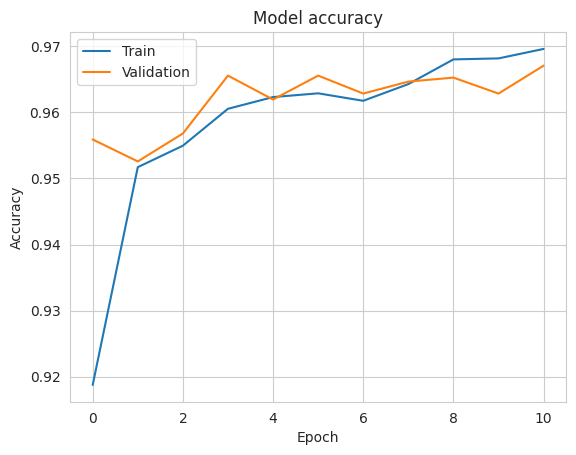

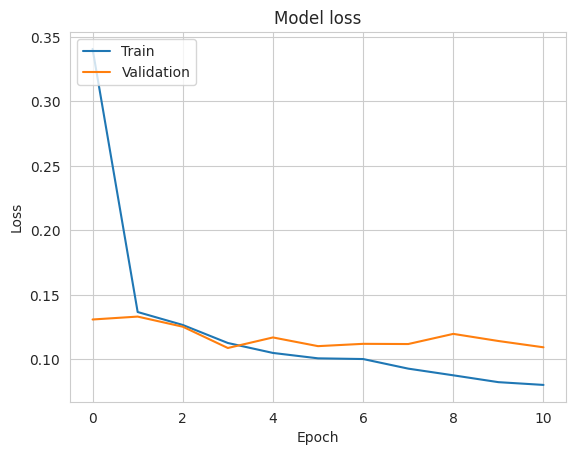

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Concatinating the history of the model
hist_1 = pd.read_csv('/kaggle/working/training_history_1.csv')
hist_2 = pd.read_csv('/kaggle/working/training_history_2.csv')
#hist_3 = pd.read_csv('/kaggle/working/training_history_3.csv')


total_hist = pd.concat([hist_1,hist_2],axis=0).reset_index()
total_hist

In [ ]:
plt.plot(total_hist['accuracy'])
plt.plot(total_hist['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(total_hist['loss'])
plt.plot(total_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
test_labels = test_gen_new.classes
predictions = model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)
     

report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)
     


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step
              precision    recall  f1-score   support

  non-tumour       0.96      0.96      0.96      1336
      tumour       0.97      0.97      0.97      1975

    accuracy                           0.97      3311
   macro avg       0.96      0.96      0.96      3311
weighted avg       0.97      0.97      0.97      3311



In [20]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

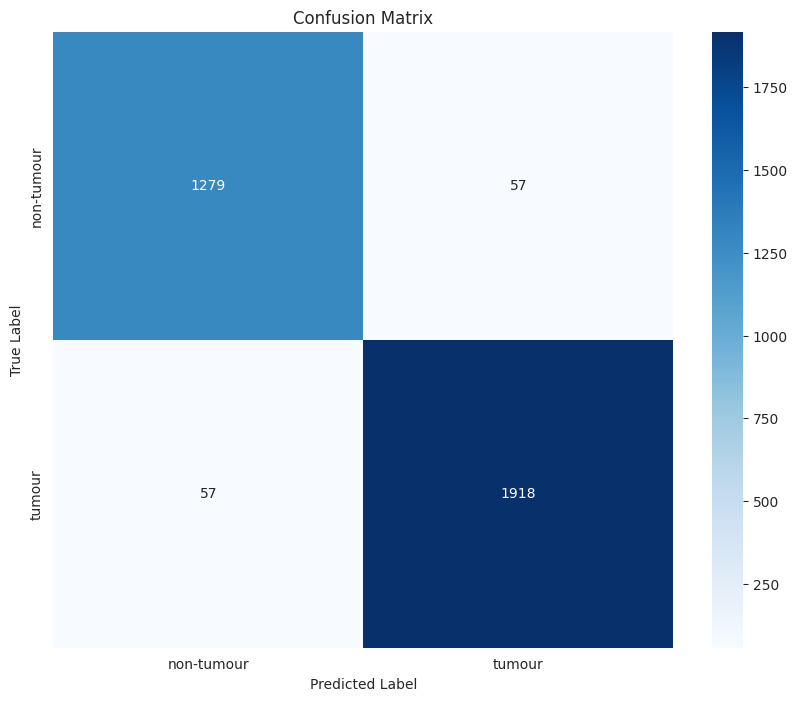

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
model.save('model.h5')
model.save('model.keras')